### Basic Tutorial: Jax Version


The `LANfactory` package is a light-weight convenience package for training `likelihood approximation networks` (LANs) in torch (or keras), 
starting from supplied training data.

[LANs](https://elifesciences.org/articles/65074), although more general in potential scope of applications, were conceived in the context of sequential sampling modeling
to account for cognitive processes giving rise to *choice* and *reaction time* data in *n-alternative forced choice experiments* commonly encountered in the cognitive sciences.

In this quick tutorial we will use the [`ssms`](https://github.com/AlexanderFengler/ssm_simulators) package to generate our training data using such a sequential sampling model (SSM). The use of of the `LANfactory` package is in no way bound to utilize this `ssms` package.

#### Install

To install the `ssms` package type,

`pip install git+https://github.com/AlexanderFengler/ssm_simulators`

To install the `LANfactory` package type,

`pip install git+https://github.com/AlexanderFengler/LANfactory`

Necessary dependency should be installed automatically in the process.

In [2]:
import ssms
import lanfactory
import os
import numpy as np
from copy import deepcopy
import torch

In [3]:
MODEL = "ddm"
RUN_SIMS = False
DEVICE = "cpu"

In [4]:
# Initialize the generator config (for MLP LANs)
generator_config = deepcopy(ssms.config.data_generator_config["lan"])
# Specify generative model (one from the list of included models mentioned above)
generator_config["model"] = MODEL
# Specify number of parameter sets to simulate
generator_config["n_parameter_sets"] = 256
# Specify how many samples a simulation run should entail
generator_config["n_samples"] = 2000
# Specify folder in which to save generated data
generator_config["output_folder"] = "data/lan_mlp/"

# Make model config dict
model_config = ssms.config.model_config[MODEL]

In [5]:
generator_config["output_folder"] = (
    "data/lan_mlp/"
    + generator_config["model"]
    + "/"
    + str(generator_config["n_samples"])
    + "_"
    + str(generator_config["n_training_samples_by_parameter_set"])
    + "/"
)

In [6]:
if RUN_SIMS:
    n_datafiles = 20
    for i in range(n_datafiles):
        print("Datafile: ", i)
        my_dataset_generator = ssms.dataset_generators.lan_mlp.data_generator(
            generator_config=generator_config, model_config=model_config
        )
        training_data = my_dataset_generator.generate_data_training_uniform(save=True)

In [7]:
import pickle

folder_ = "../data/lan_mlp/" + MODEL + "/"
files_ = [folder_ + file_ for file_ in os.listdir(folder_)]

my_data = pickle.load(
    open(
        files_[0],
        "rb",
    )
)

In [8]:
from copy import deepcopy

network_config = deepcopy(lanfactory.config.network_configs.network_config_mlp)
network_config["layer_sizes"] = [100, 100, 100, 1]
network_config["activations"] = ["tanh", "tanh", "tanh", "linear"]

print("Network config: ")
print(network_config)

train_config = deepcopy(lanfactory.config.network_configs.train_config_mlp)
train_config["learning_rate"] = 0.000002

print("Train config: ")
print(train_config)

Network config: 
{'layer_sizes': [100, 100, 100, 1], 'activations': ['tanh', 'tanh', 'tanh', 'linear'], 'train_output_type': 'logprob'}
Train config: 
{'cpu_batch_size': 128, 'gpu_batch_size': 256, 'n_epochs': 5, 'optimizer': 'adam', 'learning_rate': 2e-06, 'lr_scheduler': 'reduce_on_plateau', 'lr_scheduler_params': {}, 'weight_decay': 0.0, 'loss': 'huber', 'save_history': True}


In [9]:
network_config

{'layer_sizes': [100, 100, 100, 1],
 'activations': ['tanh', 'tanh', 'tanh', 'linear'],
 'train_output_type': 'logprob'}

In [10]:
train_config["cpu_batch_size"] = 2048
train_config["gpu_batch_size"] = 2048
train_config["n_epochs"] = 20

In [11]:
train_config

{'cpu_batch_size': 2048,
 'gpu_batch_size': 2048,
 'n_epochs': 20,
 'optimizer': 'adam',
 'learning_rate': 2e-06,
 'lr_scheduler': 'reduce_on_plateau',
 'lr_scheduler_params': {},
 'weight_decay': 0.0,
 'loss': 'huber',
 'save_history': True}

In [12]:
folder_ = "../data/lan_mlp/" + MODEL + "/"
file_list_ = [folder_ + file_ for file_ in os.listdir(folder_)][:3]

# Training dataset
jax_training_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_training_dataloader = torch.utils.data.DataLoader(
    jax_training_dataset, shuffle=True, batch_size=None, num_workers=1, pin_memory=True
)

# Validation dataset
jax_validation_dataset = lanfactory.trainers.DatasetTorch(
    file_ids=file_list_,
    batch_size=(
        train_config[DEVICE + "_batch_size"]
        if torch.cuda.is_available()
        else train_config[DEVICE + "_batch_size"]
    ),
    label_lower_bound=np.log(1e-10),
    features_key="lan_data",
    label_key="lan_labels",
    out_framework="jax",
)

jax_validation_dataloader = torch.utils.data.DataLoader(
    jax_validation_dataset,
    shuffle=True,
    batch_size=None,
    num_workers=1,
    pin_memory=True,
)

In [13]:
cnt = 0
for xb, yb in jax_training_dataloader:
    print(xb)
    print(yb)
    cnt += 1
    if cnt > 0:
        break

tensor([[-0.6565,  0.5889,  0.6653,  1.7810,  2.1035,  1.0000],
        [ 0.7106,  1.1564,  0.5157,  0.3207,  1.0960,  1.0000],
        [ 0.9426,  0.6258,  0.3031,  0.6190,  0.7914,  1.0000],
        ...,
        [-0.6373,  1.2184,  0.5724,  1.5746,  3.2242, -1.0000],
        [-2.3111,  1.3941,  0.8636,  0.4946,  1.3389, -1.0000],
        [-2.5116,  0.3034,  0.2683,  0.3998,  0.4072, -1.0000]])
tensor([[-0.8507],
        [-0.7414],
        [-0.0710],
        ...,
        [-1.5046],
        [-0.0316],
        [ 2.8727]])


In [14]:
# LOAD NETWORK
jax_net = lanfactory.trainers.JaxMLPFactory(network_config=network_config, train=True)
pickle.dump(
    network_config,
    open("../data/jax_models/" + MODEL + "/jax_network_config.pickle", "wb"),
)

In [15]:
jax_trainer = lanfactory.trainers.ModelTrainerJaxMLP(
    train_config=train_config,
    model=jax_net,
    train_dl=jax_training_dataloader,
    valid_dl=jax_validation_dataloader,
    pin_memory=True,
)

In [16]:
train_state = jax_trainer.train_and_evaluate(
    output_folder="../data/jax_models/" + MODEL + "/",
    output_file_id=MODEL,
    run_id="test_run_notebook",
    wandb_on=False,
    wandb_project_id="test_run_notebook",
    save_data_details=True,
    verbose=1,
    save_all=True,
)

Found folder:  ..
Moving on...
Found folder:  ../data
Moving on...
Found folder:  ../data/jax_models
Moving on...
Found folder:  ../data/jax_models/ddm
Moving on...
Epoch: 0 of 20
Training - Step: 0 of 14646 - Loss: 4.5214987
Training - Step: 1000 of 14646 - Loss: 0.21748759
Training - Step: 2000 of 14646 - Loss: 0.093032986
Training - Step: 3000 of 14646 - Loss: 0.06611438
Training - Step: 4000 of 14646 - Loss: 0.060834274
Training - Step: 5000 of 14646 - Loss: 0.06890257
Training - Step: 6000 of 14646 - Loss: 0.06966375
Training - Step: 7000 of 14646 - Loss: 0.07706358
Training - Step: 8000 of 14646 - Loss: 0.092329554
Training - Step: 9000 of 14646 - Loss: 0.077202246
Training - Step: 10000 of 14646 - Loss: 0.10673015
Training - Step: 11000 of 14646 - Loss: 0.084473066
Training - Step: 12000 of 14646 - Loss: 0.07806848
Training - Step: 13000 of 14646 - Loss: 0.077695556
Training - Step: 14000 of 14646 - Loss: 0.10682073
Epoch 0/20 time: 54.20230793952942s
Validation - Step: 0 of 146

In [21]:
# Loaded Net
jax_infer = lanfactory.trainers.JaxMLPFactory(
    # network_config="../data/jax_models/"
    # + MODEL
    # + "/"
    # + "test_run_notebook"
    # + "_lan_ddm__network_config.pickle",
    network_config=network_config,
    train=False,
)

In [22]:
forward_pass = jax_infer.make_forward_partial()

ValueError: state argument has to be a dictionary or a string!

In [23]:
forward_pass, forward_pass_jitted = jax_infer.make_forward_partial(
    seed=42,
    input_dim=model_config["n_params"] + 2,
    state="../data/jax_models/" + MODEL + "/test_run_notebook_lan_ddm__train_state.jax",
    add_jitted=True,
)

passing through identity


In [28]:
forward_pass(np.ones((10, 6))).shape

passing through identity


(10, 1)

: 

In [36]:
import jax.numpy as jnp

# Test parameters:
theta = deepcopy(ssms.config.model_config[MODEL]["default_params"])

theta[0] = 0.2
theta[3] = 1.0

# Comparison simulator run
sim_out = ssms.basic_simulators.simulator.simulator(
    model=MODEL, theta=theta, n_samples=50000
)

# Make input metric
input_mat = jnp.zeros((2000, len(theta) + 2))
for i in range(len(theta)):
    input_mat = input_mat.at[:, i].set(jnp.ones(2000) * theta[i])

input_mat = input_mat.at[:, len(theta)].set(
    jnp.array(
        np.concatenate(
            [
                np.linspace(5, 0, 1000).astype(np.float32),
                np.linspace(0, 5, 1000).astype(np.float32),
            ]
        )
    )
)
input_mat = input_mat.at[:, len(theta) + 1].set(
    jnp.array(
        np.concatenate([np.repeat(-1.0, 1000), np.repeat(1.0, 1000)]).astype(np.float32)
    )
)

net_out = forward_pass_jitted(input_mat)

(array([1.07477757e-04, 2.14955515e-04, 1.07477757e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 6.44866544e-04, 4.29911029e-04,
        6.44866544e-04, 6.44866544e-04, 6.44866544e-04, 8.59822058e-04,
        9.67299815e-04, 1.50468860e-03, 1.50468860e-03, 2.25703290e-03,
        3.22433272e-03, 2.57946617e-03, 4.83649908e-03, 4.62154356e-03,
        8.16830955e-03, 8.16830955e-03, 9.99543142e-03, 1.33272419e-02,
        1.79487855e-02, 2.28927623e-02, 2.90189945e-02, 3.49302711e-02,
        4.37434472e-02, 5.45987007e-02, 7.39446970e-02, 8.72719389e-02,
        1.13711467e-01, 1.40903340e-01, 1.71104590e-01, 2.14418126e-01,
        2.61385906e-01, 3.31676359e-01, 3.45433512e-01, 1.28328442e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.53048326e-01,
        5.10089436e-01, 4.96224805e-01, 4.30878329e-01, 3.279146

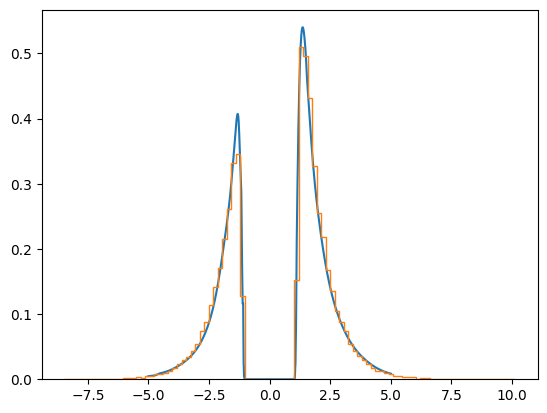

In [37]:
from matplotlib import pyplot as plt

plt.plot(np.linspace(-5, 5, 2000).astype(np.float32), np.exp(net_out))

plt.hist(
    sim_out["rts"] * sim_out["choices"],
    bins=100,
    histtype="step",
    fill=None,
    density=True,
)